In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# def load_balt_trend_data(name):
    
#     file_name = 'BPD_Part_1_Victim_Based_Crime_Data.csv'
#     df = pd.read_csv(file_name)

#     df = df.set_index(pd.DatetimeIndex(df.CrimeDate))
    
#     crime_types = pd.get_dummies(df['Description'])
#     df2 = pd.concat([df, crime_types], axis=1)
#     df2.drop(['Description'], axis=1, inplace=True)
    
#     return pd.Series(df2[name].mean(), df2.index)

In [3]:
# def plot_trend_data(ax, name, series):
#     ax.plot(series.index.date, series)
#     ax.set_title(f"Baltimore Crime Trend for {name}")
#     ax.set_ylim((0, 2))

# balt_crimes = ['AGG. ASSAULT', 'ARSON', 'AUTO THEFT','BURGLARY','COMMON ASSAULT','HOMICIDE','LARCENY','LARCENY FROM AUTO','RAPE','ROBBERY - CARJACKING','ROBBERY - COMMERCIAL','ROBBERY - RESIDENCE','ROBBERY - STREET', 'SHOOTING']

# balt_trends = {
#     name: load_balt_trend_data(name)
#     for name in balt_crimes
# }

In [4]:
# fig, axs = plt.subplots(len(balt_trends), figsize=(10, 80))

# for ax, name in zip(axs, balt_crimes):
#     plot_trend_data(ax, name, load_balt_trend_data(name))
    
# plt.tight_layout()

In [5]:
file_name = 'BPD_Part_1_Victim_Based_Crime_Data.csv'
df = pd.read_csv(file_name)
df = df.set_index(pd.DatetimeIndex(df.CrimeDate))
crime_types = pd.get_dummies(df['Description'])
df2 = pd.concat([df, crime_types], axis=1)
df2.drop(['Description'], axis=1, inplace=True)
df2 = df2[df2.index.year > 2013]

In [6]:
balt_crimes = ['AGG. ASSAULT', 'ARSON', 'AUTO THEFT',
               'BURGLARY','COMMON ASSAULT','HOMICIDE',
               'LARCENY','LARCENY FROM AUTO','RAPE',
               'ROBBERY - CARJACKING','ROBBERY - COMMERCIAL',
               'ROBBERY - RESIDENCE','ROBBERY - STREET', 'SHOOTING']

In [7]:
df2['WEEK'] = df2.index.week
df2['YEAR'] = df2.index.year

In [8]:
# def plot_trend_data(ax, name, series):
#     ax.plot(series.index.date, series)
#     ax.set_title(f"Baltimore Crime Trend for {name}")
#     ax.set_ylim((0, 2))

# fig, ax = plt.subplots(figsize=(14, 2))
# plot_trend_data(ax, 'ARSON', df2['ARSON'])

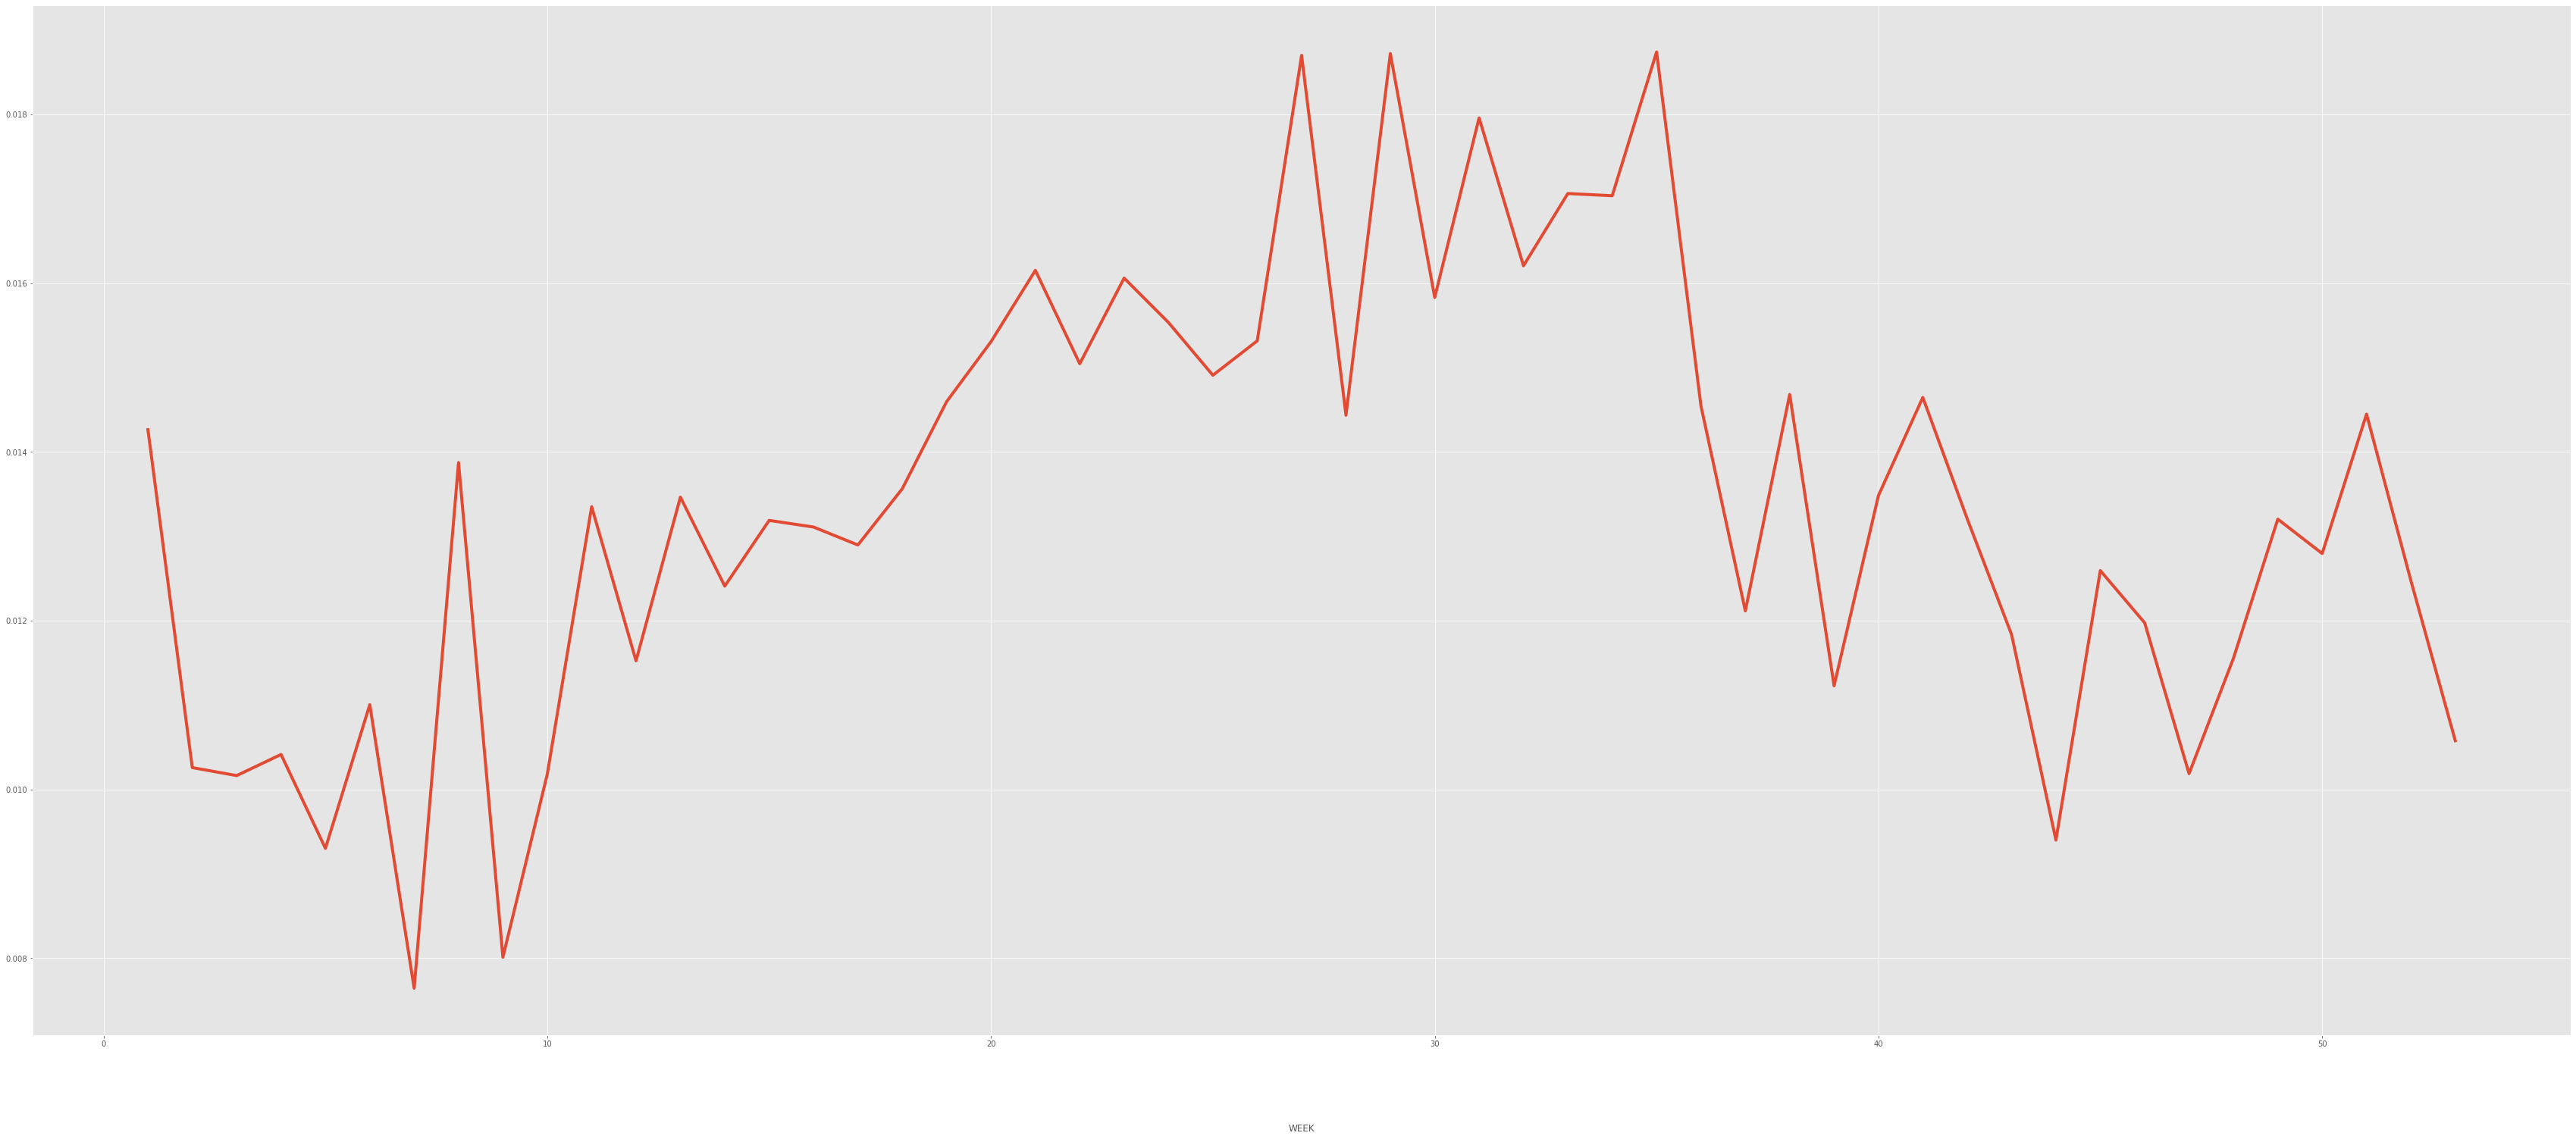

In [9]:
fig, ax = plt.subplots(figsize=(60,25))

SMALL = 40
MEDIUM = 60
BIGGER = 120

plt.rc('font', size=SMALL)
plt.rc('axes', titlesize=MEDIUM)   
plt.rc('xtick', labelsize=MEDIUM)    
plt.rc('ytick', labelsize=MEDIUM)    
plt.rc('legend', fontsize=SMALL)
ax.set_xlabel('Week', labelpad=100, horizontalalignment='center')
# ax.set_facecolor('w')
df2['SHOOTING'].groupby(df2['WEEK']).mean().plot(linewidth=4)

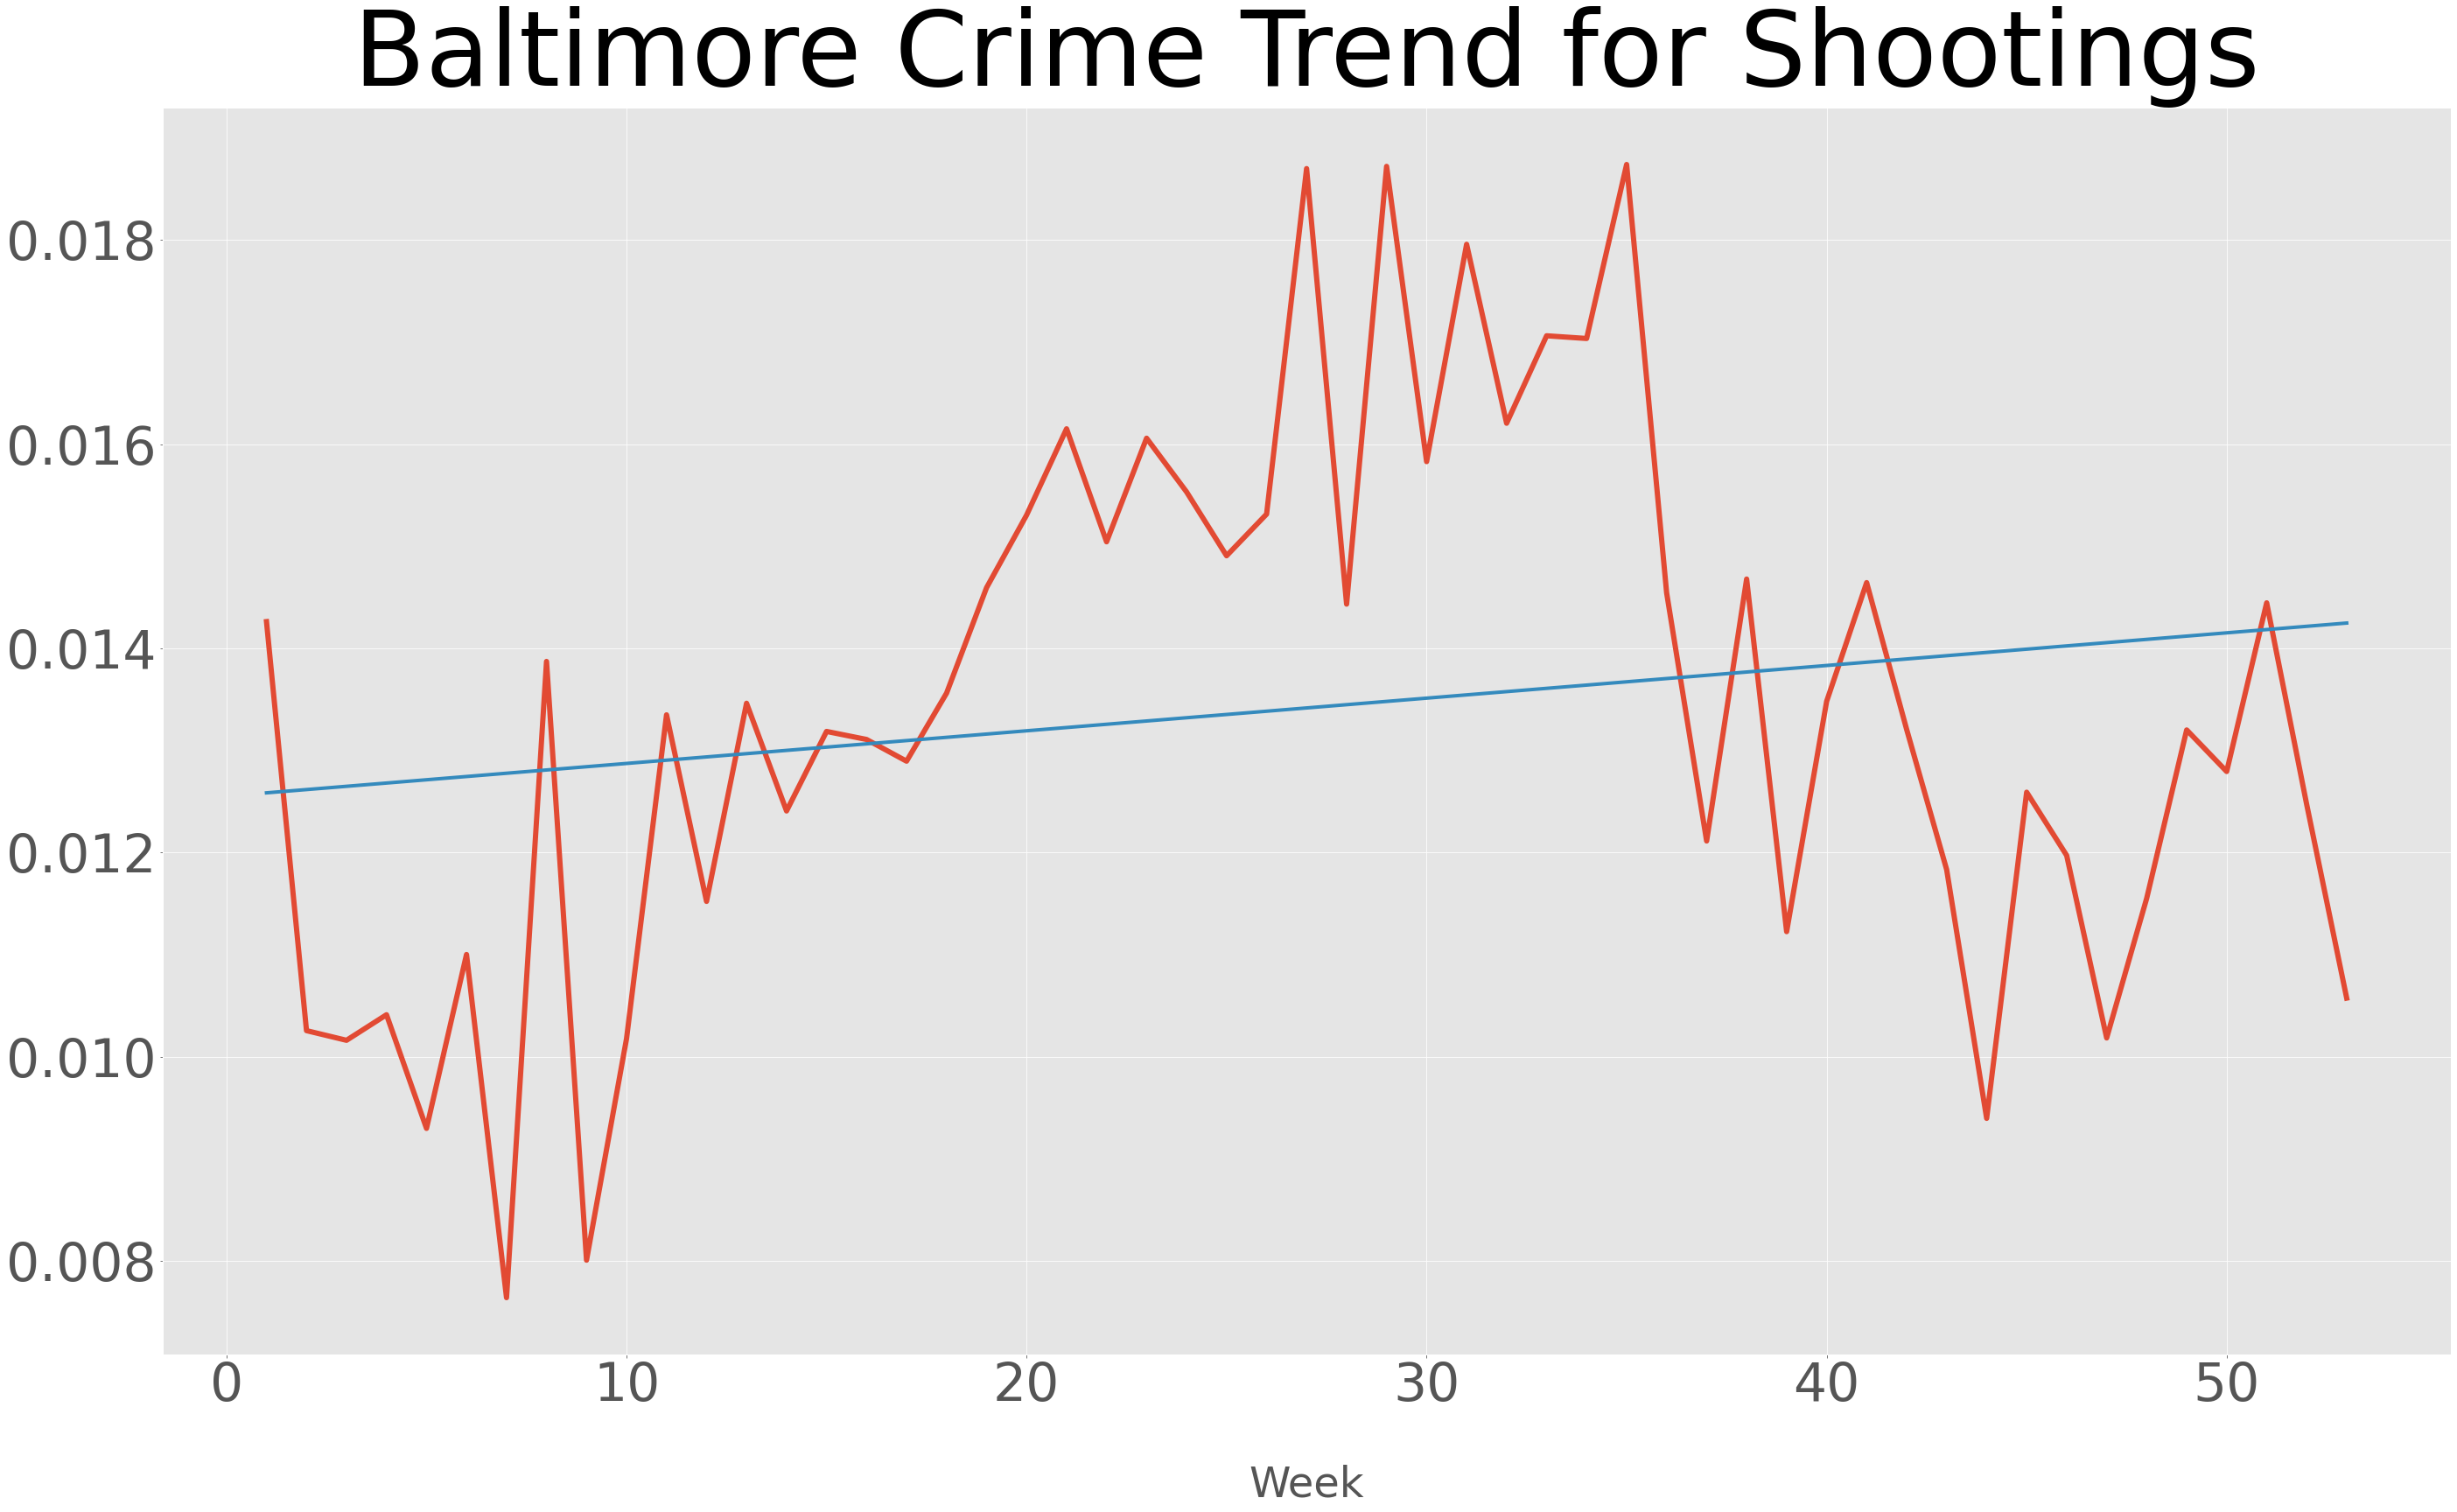

In [10]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series, linewidth=6)
    ax.set_title(f"Baltimore Crime Trend for {name}")
#     ax.set_ylim((0, 2))

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, converting to a 2-d array
    and including an intercept term."""
    return sm.add_constant(arr.reshape(-1, 1), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
#     df2['RAPE'].groupby(df2['WEEK']).mean()
    ax.plot(series.index, linear_trend)


# ax.set_facecolor('w')
fig, ax = plt.subplots(1, figsize=(40, 25))
plt.rc('font', size=SMALL)
plt.rc('axes', titlesize=BIGGER)     
plt.rc('axes', labelsize=BIGGER)   
plt.rc('xtick', labelsize=MEDIUM)
plt.rc('ytick', labelsize=MEDIUM)    
plt.rc('legend', fontsize=SMALL)
plt.rc('lines', linewidth=4)
ax.set_xlabel('Week', labelpad=60, horizontalalignment='center')
plot_linear_trend(ax, 'Shootings', df2['SHOOTING'].groupby(df2['WEEK']).mean())
plt.tight_layout()

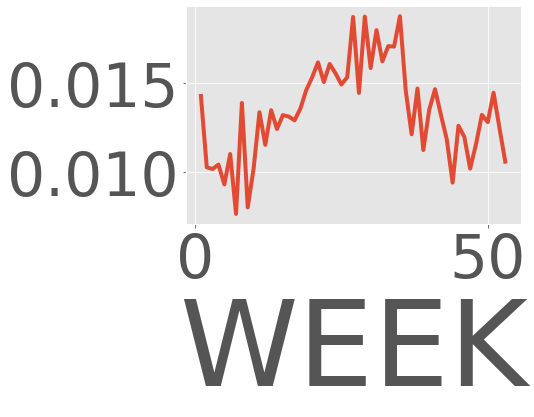

In [11]:
df2['SHOOTING'].groupby(df2['WEEK']).mean().plot()

## Detrended Shooting Series Data

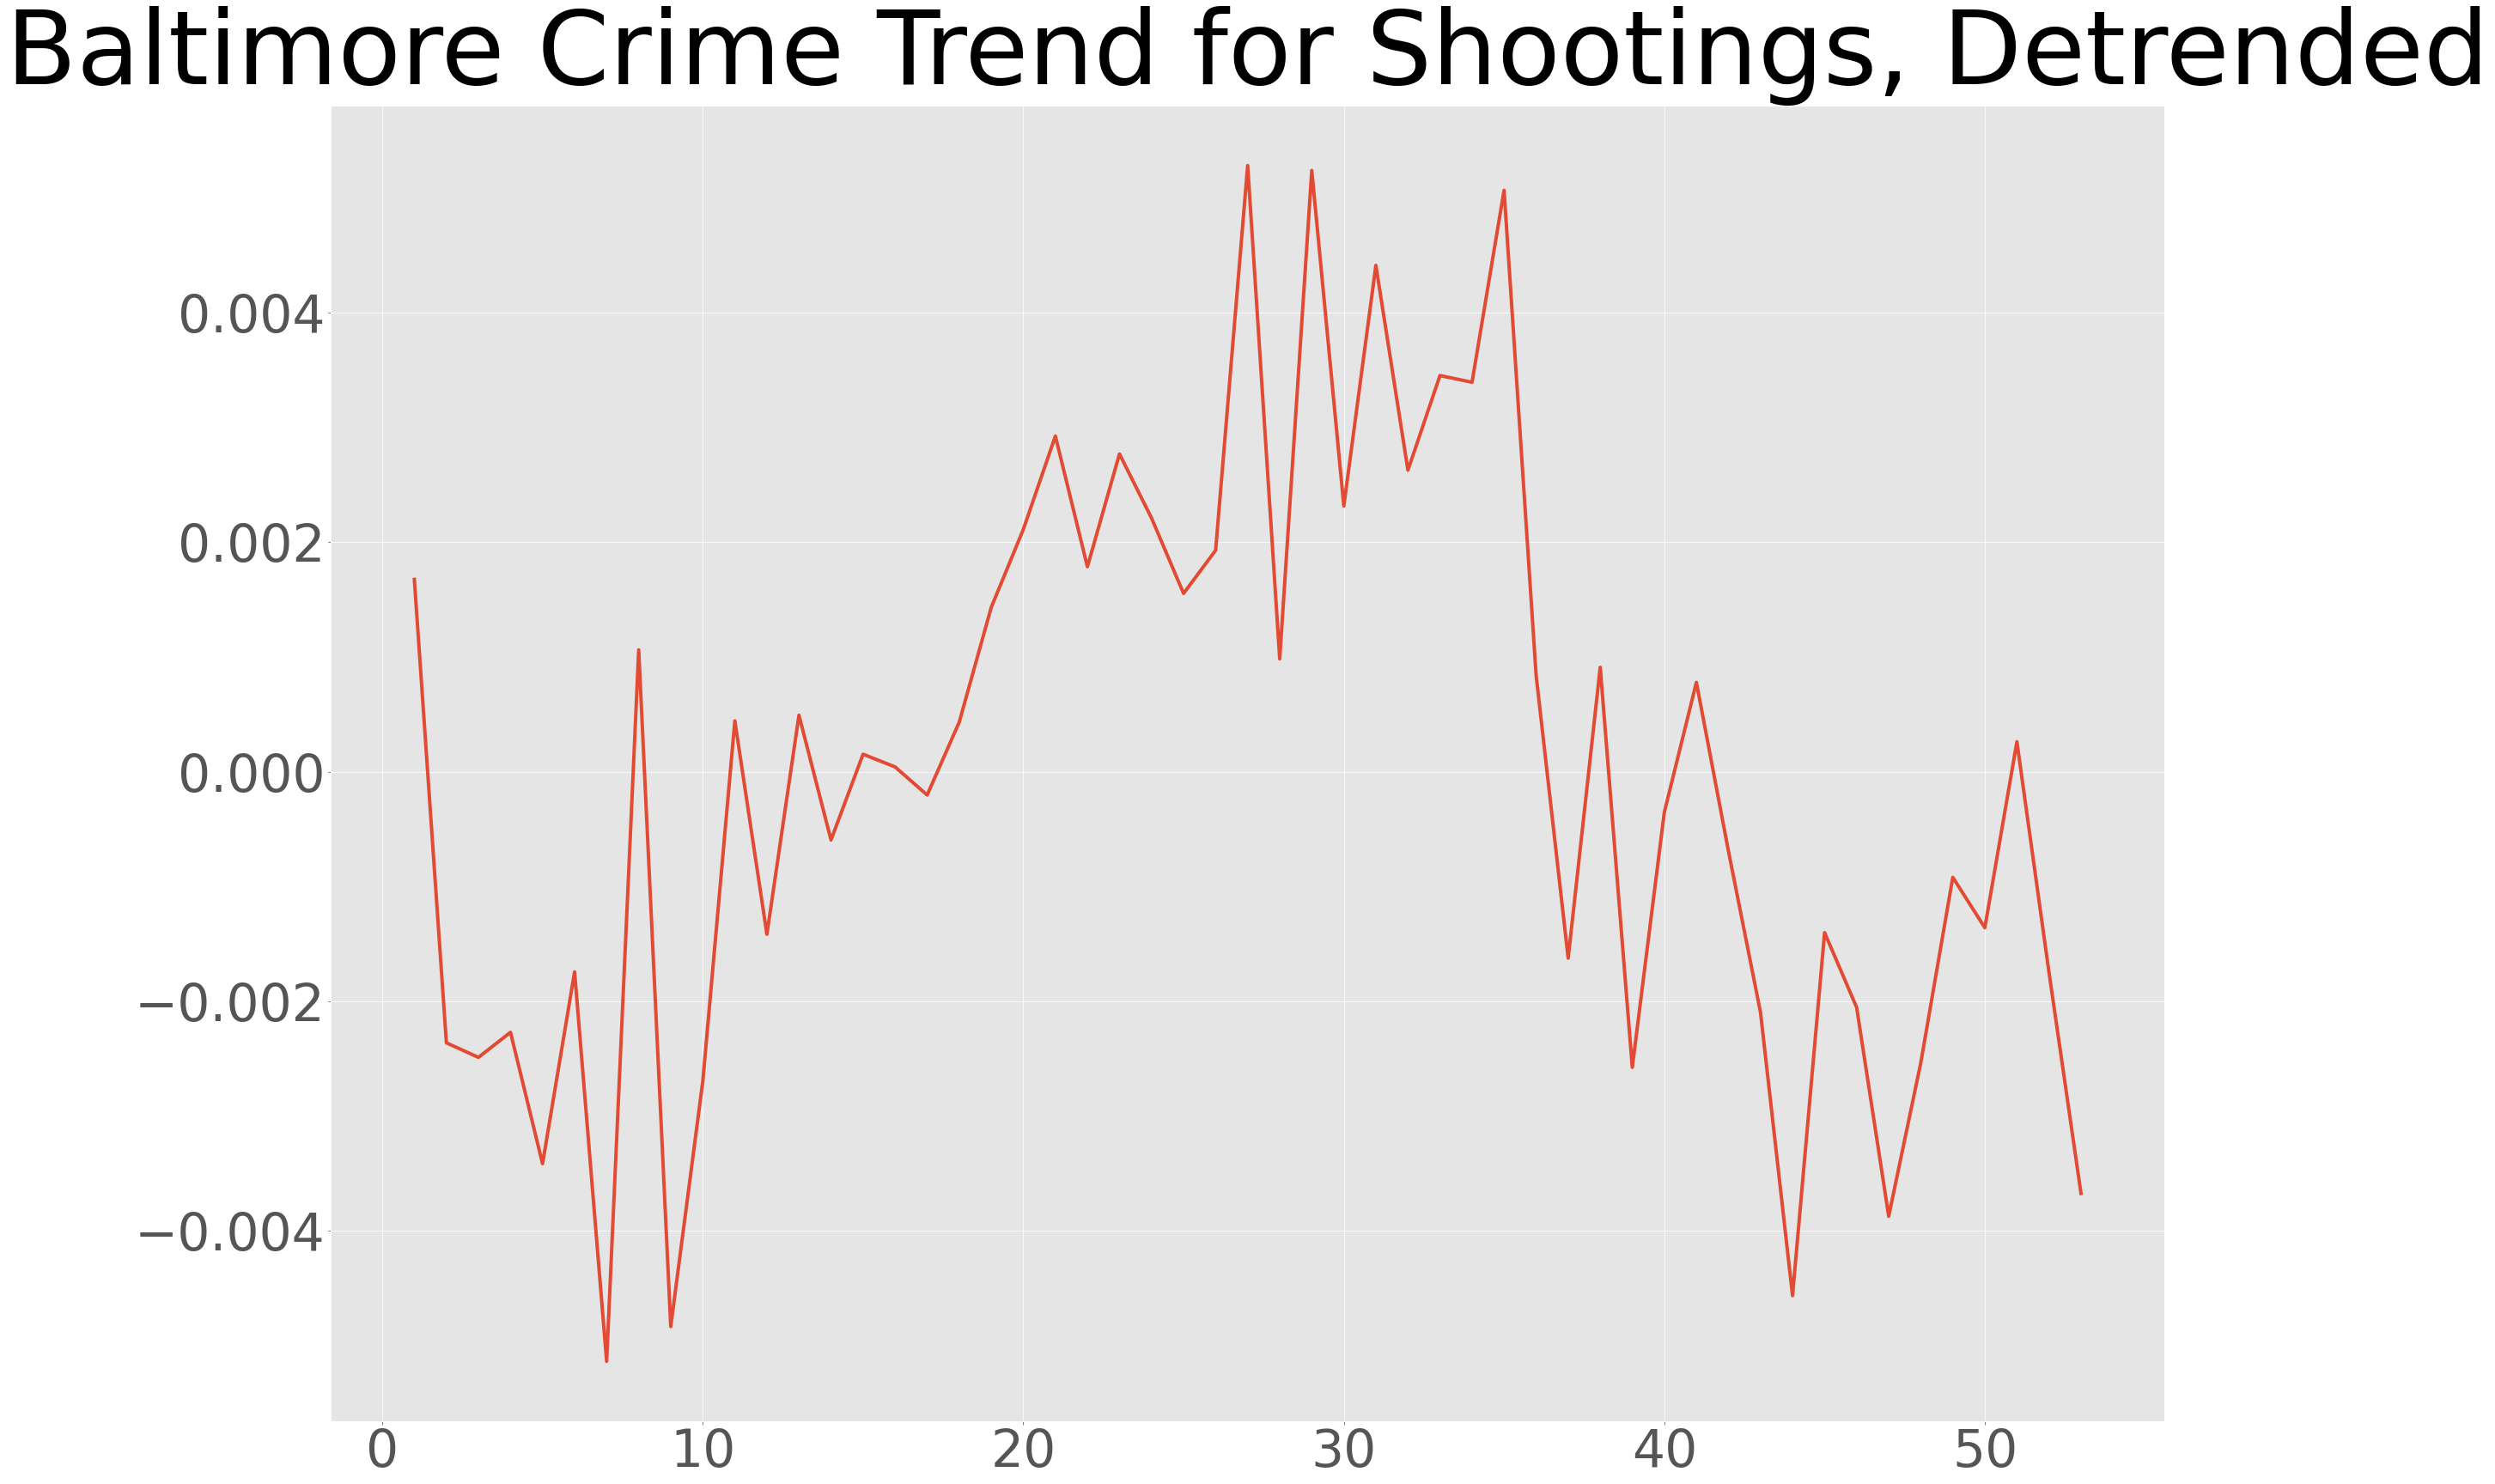

In [12]:
python_series = df2['SHOOTING'].groupby(df2['WEEK']).mean()
python_linear_trend = fit_linear_trend(python_series)
python_series_detrended = python_series - python_linear_trend

fig, ax = plt.subplots(1, figsize=(40, 25))
ax.plot(python_series_detrended.index, python_series_detrended)
ax.set_title(f"Baltimore Crime Trend for Shootings, Detrended")
plt.tight_layout()

Detrending a series is often times a first step in analysing a time series.

Many times time series show a more sophisticated trend than a simple linear increase or decrease, in these cases a more sophisticated detrending procedure is needed.

**BUT**
With my data it would silly to do so. Why? because this isnt strictly linear. the trend is not specific as of yet.

## Moving Average Trend

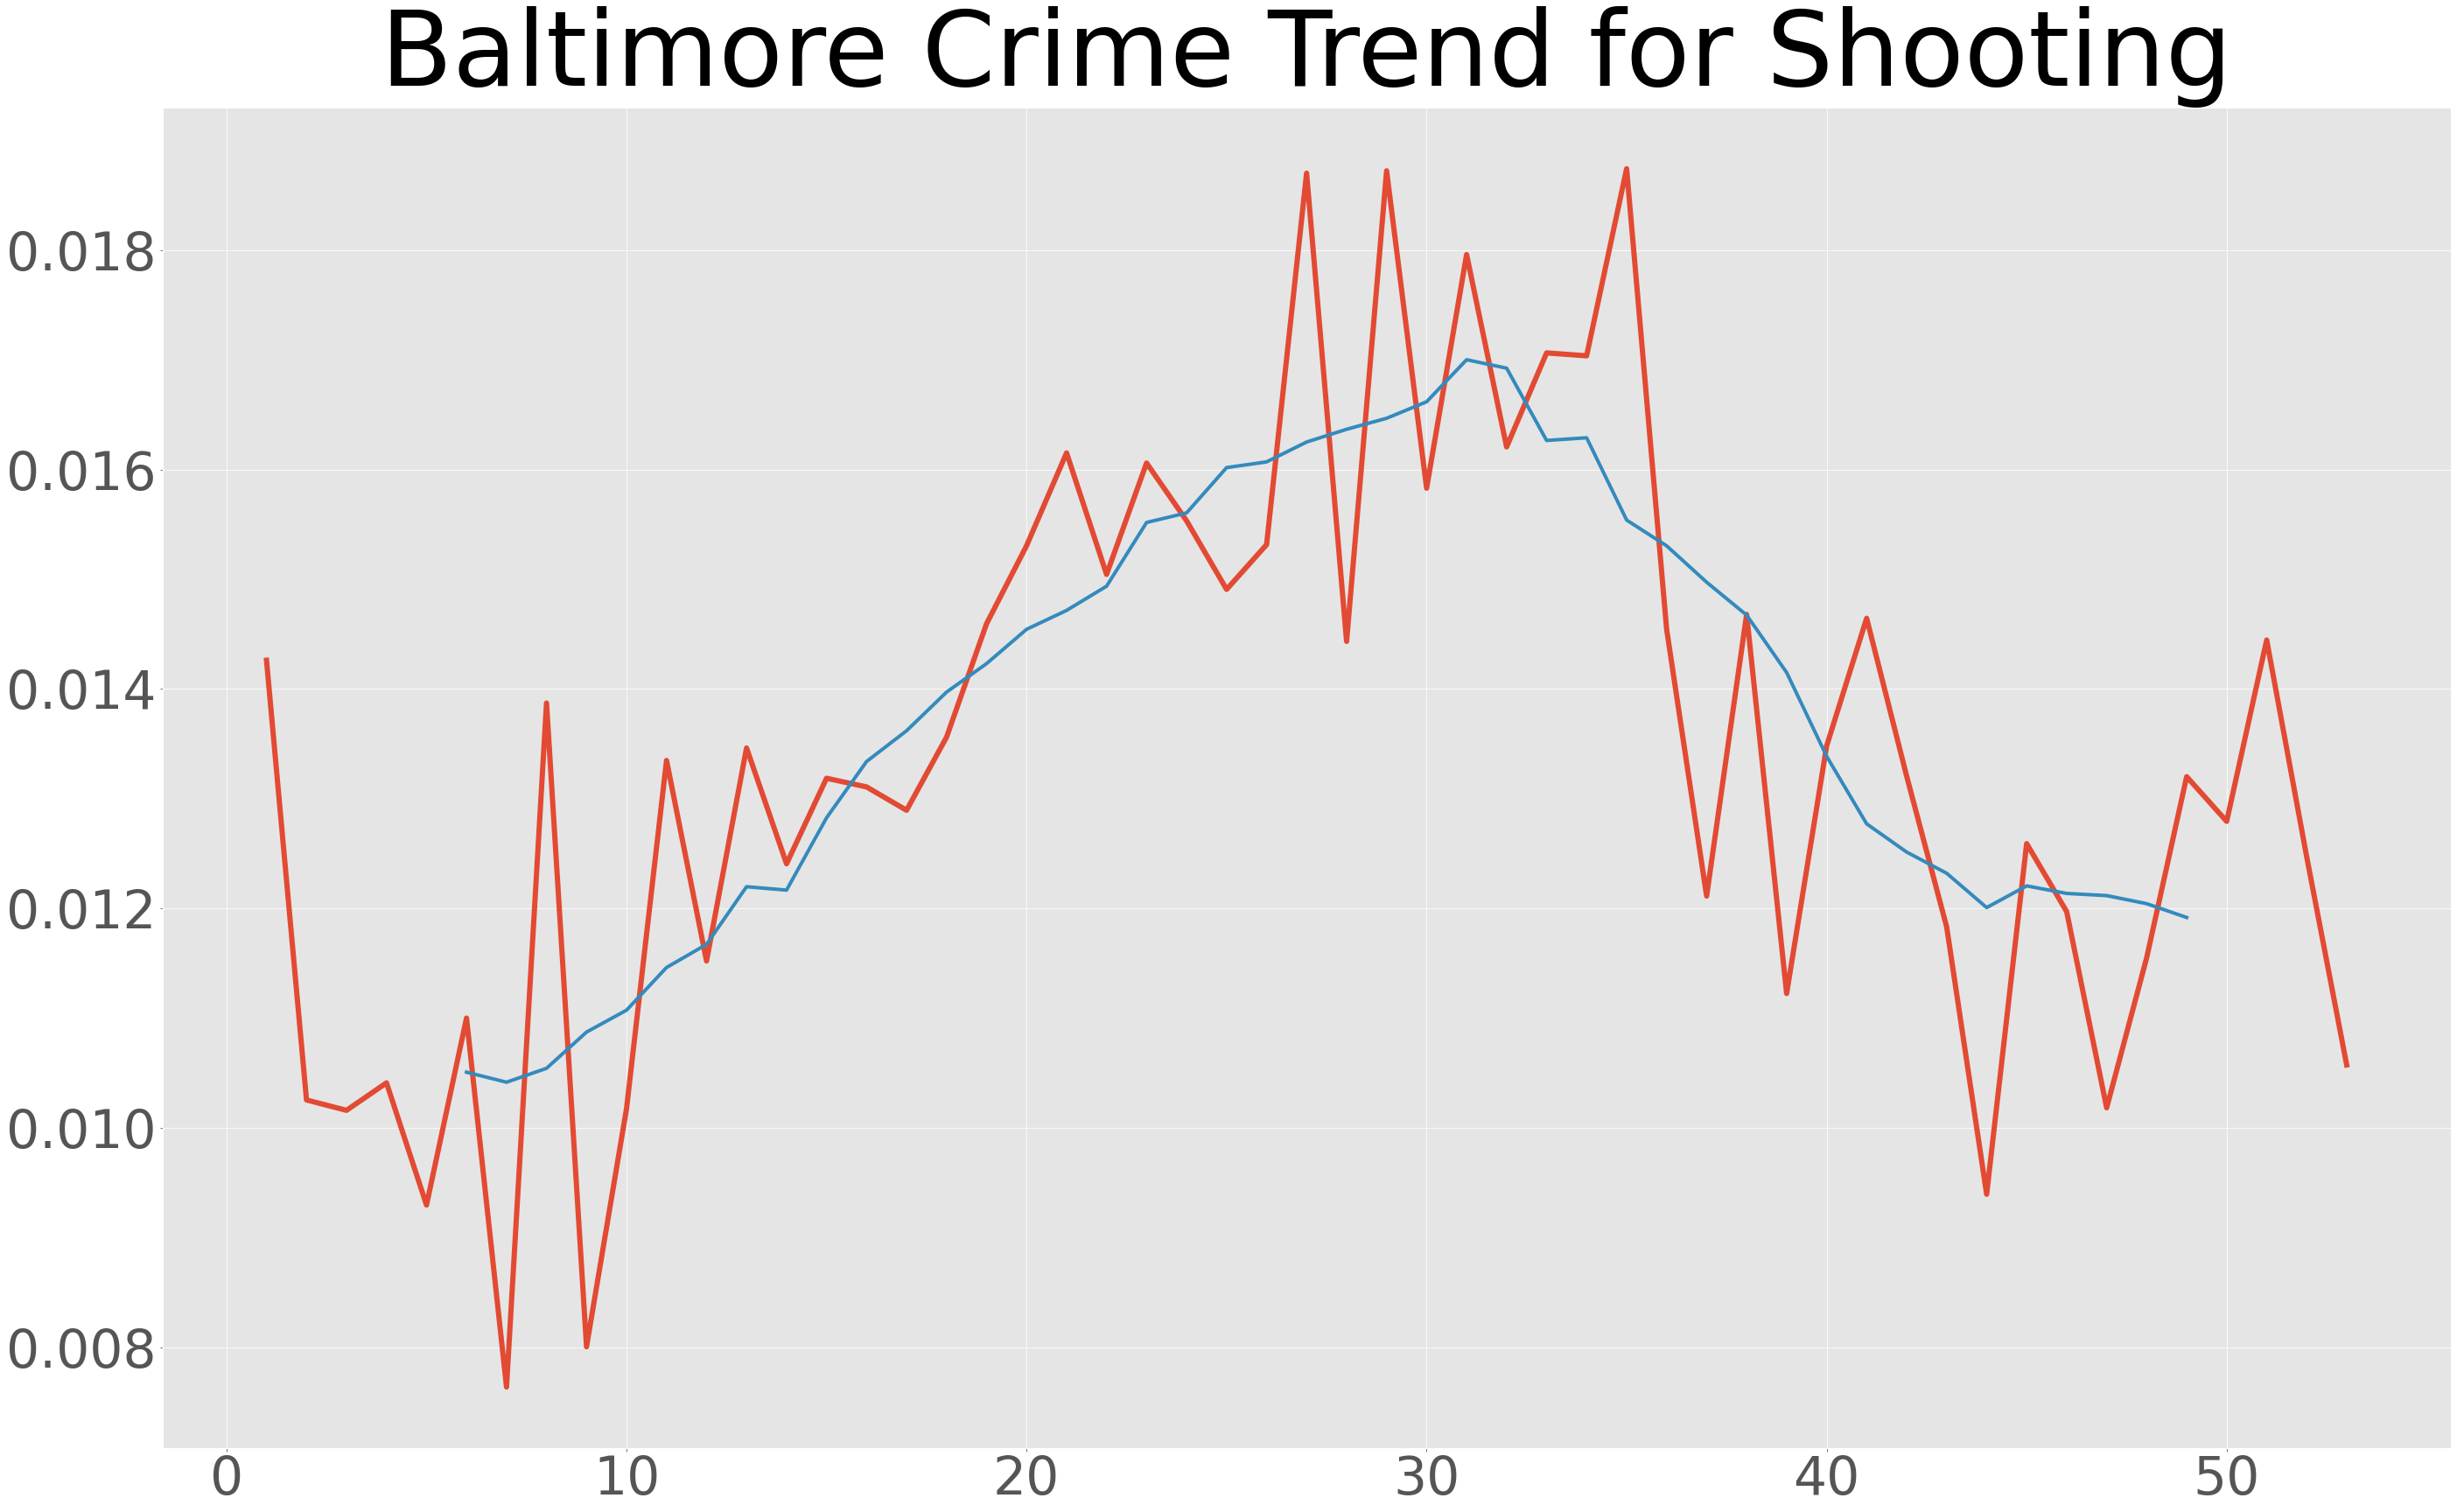

In [13]:
def fit_moving_average_trend(series, window=10):
#    return pd.rolling_mean(series, window, center=True)
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=10):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

fig, axs = plt.subplots(1, figsize=(40, 25))
plot_moving_average_trend(axs, 'Shooting', df2['SHOOTING'].groupby(df2['WEEK']).mean())
plt.tight_layout()

Varying the window param changes the quality of the moving average fit.

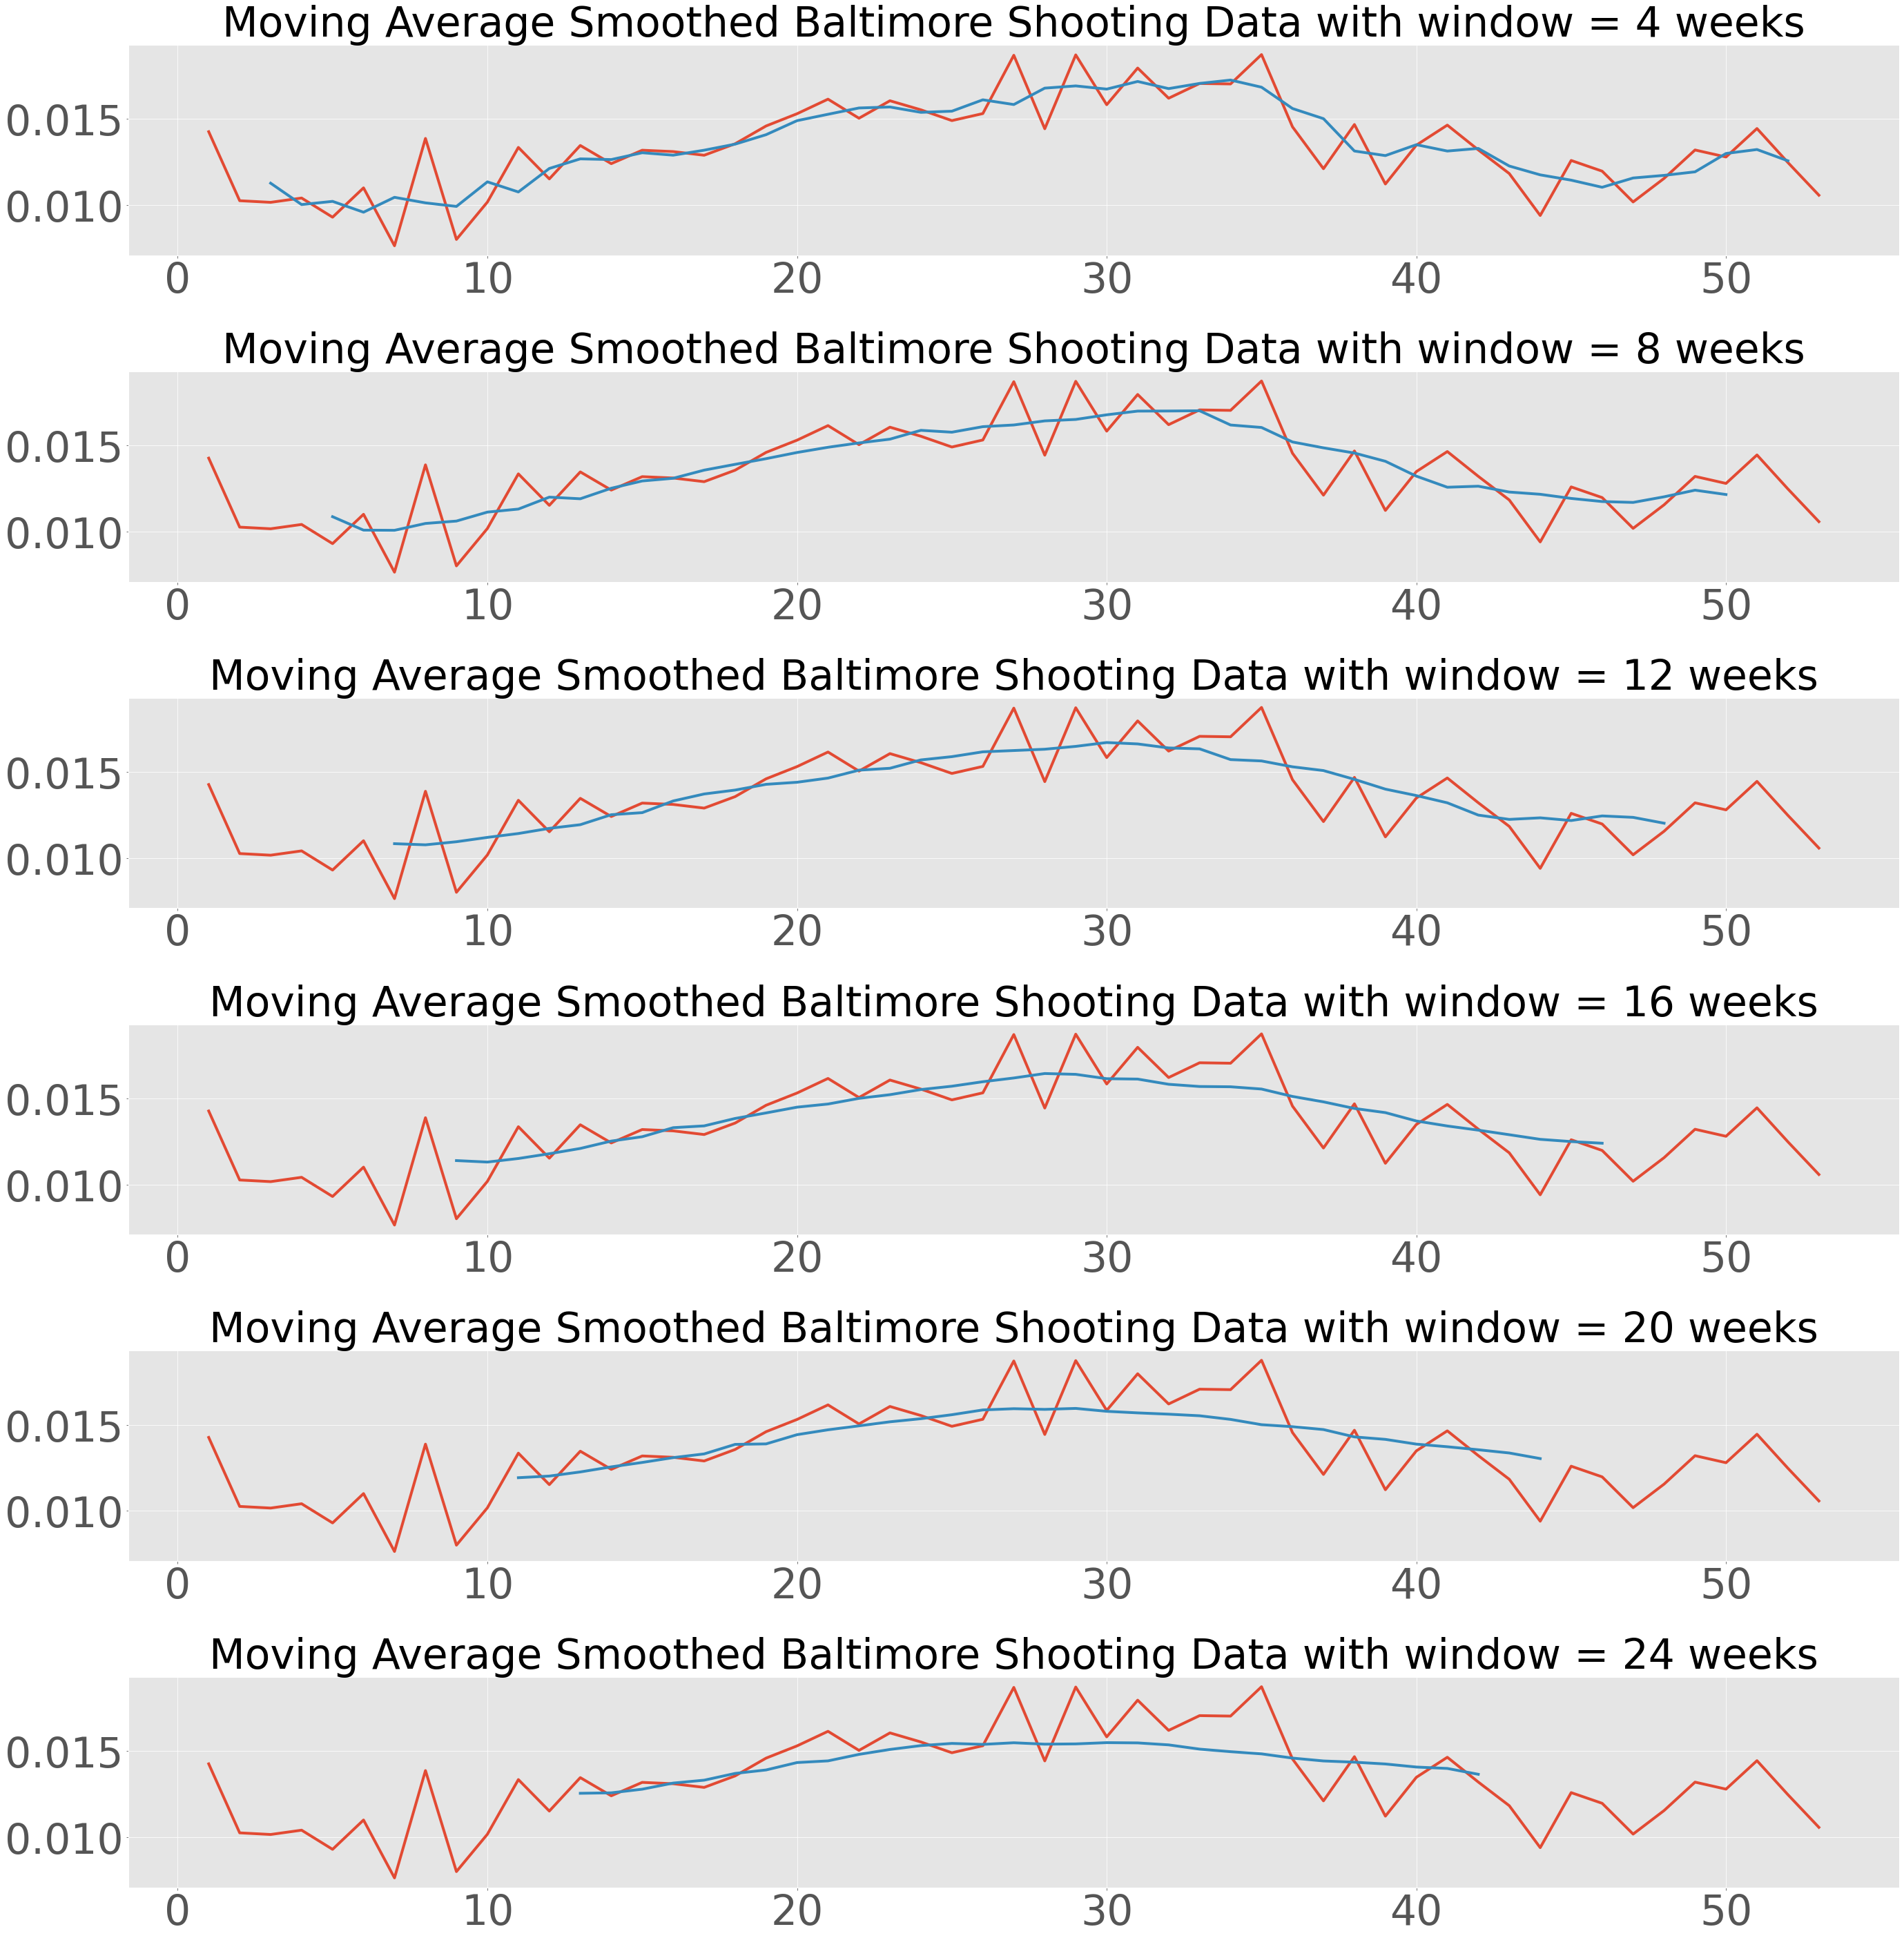

In [14]:
fig, axs = plt.subplots(6, figsize=(40, 40))

shooting_series = df2['SHOOTING'].groupby(df2['WEEK']).mean()
for i, window in enumerate([4, 8, 12, 16, 20, 24]):
    axs[i].plot(shooting_series.index, shooting_series)
    axs[i].plot(shooting_series.index, fit_moving_average_trend(shooting_series, window=window))
    axs[i].set_title("Moving Average Smoothed Baltimore Shooting Data with window = {} weeks".format(window), fontsize=MEDIUM)
    
plt.tight_layout()

## Seasonality

In [15]:
def create_weekly_dummies(series):
    week = df2.index.week
    # Only take 51 of the 52 dummies to avoid strict colinearity.
    return pd.get_dummies(week).iloc[:, :51]

In [16]:
def fit_seasonal_trend(series):
    dummies = create_weekly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [17]:
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index, seasons_average_trend, '-')

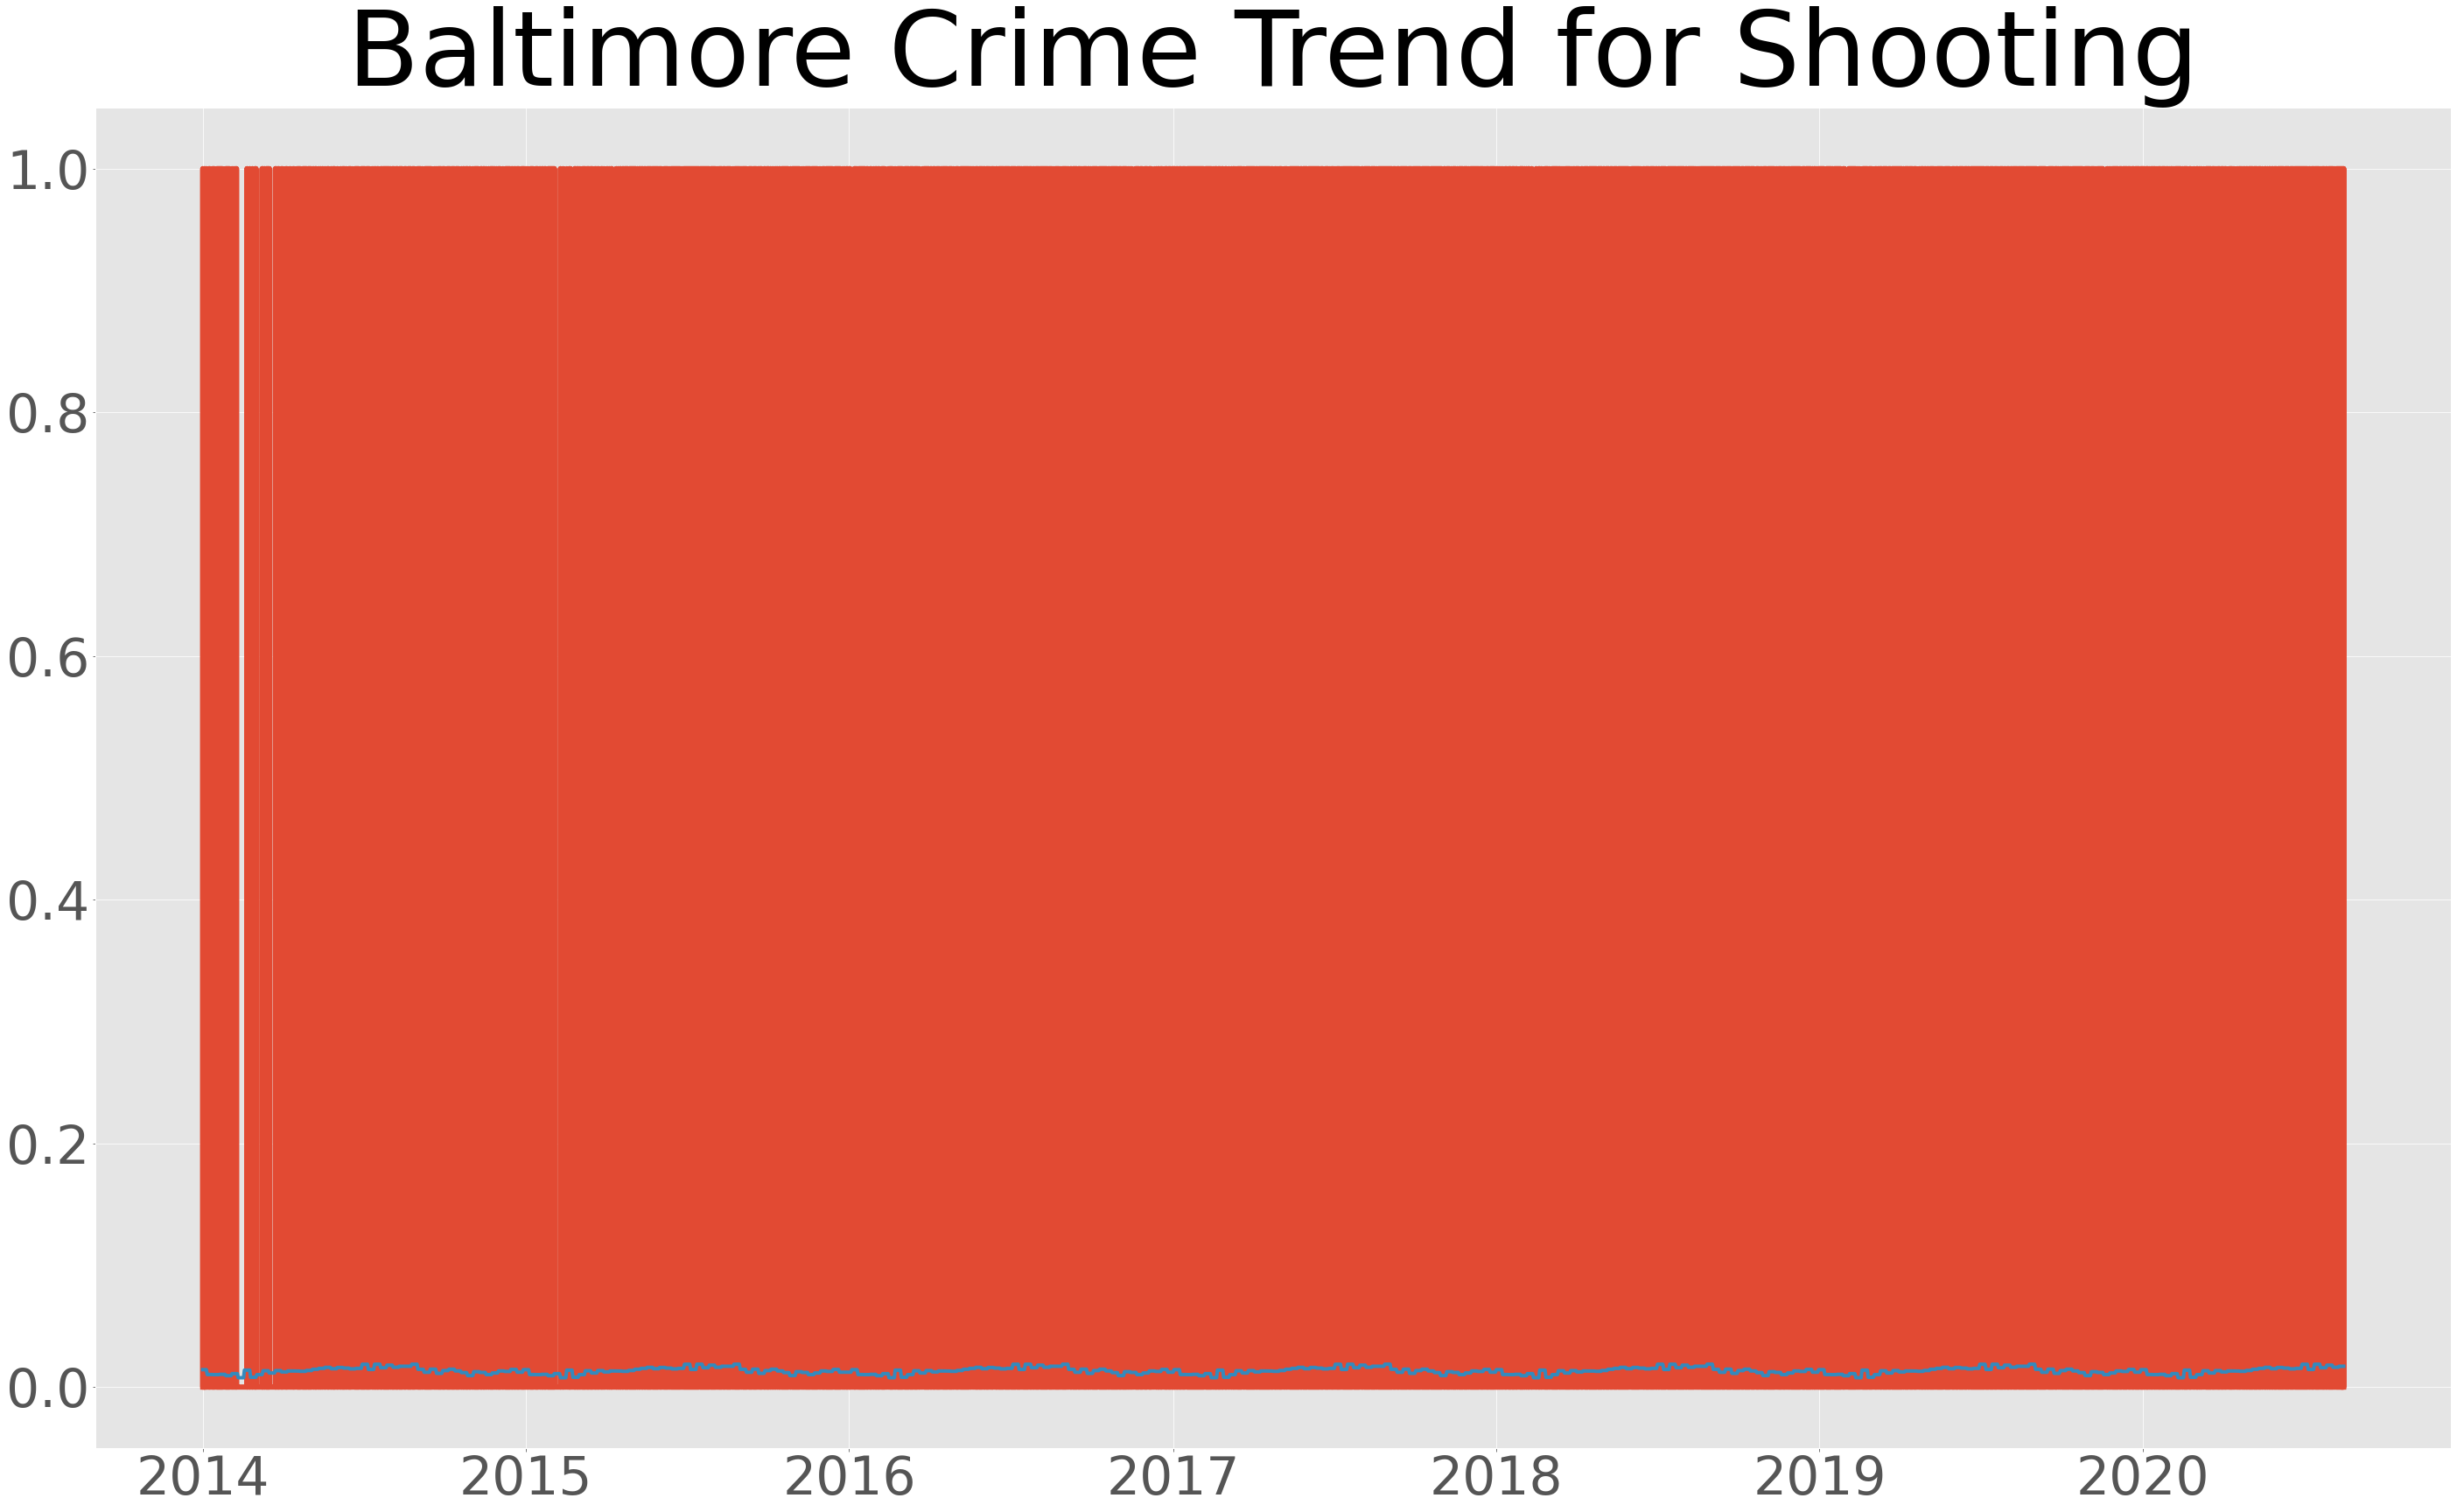

In [47]:
fig, axs = plt.subplots(figsize=(40, 25))

plot_seasonal_trend(axs, 'Shooting', df2['SHOOTING'])
plt.tight_layout()

In [ ]:
print(shooting_series.shape)

### Trend-Seasonal-Residual Decomp

In [45]:
python_decomposition = sm.tsa.seasonal_decompose(df2['SHOOTING'][:51])

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None